In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

##모델 생성

In [6]:
#기본적인 conv_block 생성
class ConvBlock(nn.Module):
    def __init__(self,in_ch, out_ch, **kwargs):
        super().__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, **kwargs),
            nn.ReLU()
        )

    def forward(self,x):
        return self.convblock(x)

In [7]:
# inceptionblock 생성
class InceptionBlock(nn.Module):
    def __init__(self, in_ch, out_ch1, red_ch3, out_ch3, red_ch5, out_ch5, pool):
        super().__init__()
        self.conv_1 = ConvBlock(in_ch, out_ch1, kernel_size=1)
        self.conv_3 = nn.Sequential(
            ConvBlock(in_ch, red_ch3, kernel_size=1),
            ConvBlock(red_ch3, out_ch3, kernel_size=3, padding=1)
        )
        self.conv_5 = nn.Sequential(
            ConvBlock(in_ch, red_ch5, kernel_size=1),
            ConvBlock(red_ch5, out_ch5, kernel_size=5, padding=2)
        )
        self.pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_ch, pool, kernel_size=1)
        )
    
    def forward(self,x):
        x_1 = self.conv_1(x)
        x_3 = self.conv_3(x)
        x_5 = self.conv_5(x)
        x_pool = self.pool(x)
        return torch.cat([x_1, x_3, x_5, x_pool], dim=1)

In [8]:
# auxiliary classifier 생성
class InceptionAux(nn.Module):
    def __init__(self, in_ch, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.AvgPool2d(kernel_size=5, stride=3),
            ConvBlock(in_ch, 128, kernel_size=1)
        )
        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.7),
            nn.Linear(1024, num_classes)
        )

    def forward(self,x):
        out = self.conv(x)
        out = out.view(out.size(0),-1)
        out = self.fc(out)
        return out

In [9]:
# GoogLeNet 생성
class GooLeNet(nn.Module):
    def __init__(self, in_ch, num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        self.trainig = True

        self.conv1 = nn.Sequential(
            ConvBlock(in_ch, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.LocalResponseNorm(2)
        )

        self.conv2 = nn.Sequential(
            ConvBlock(64, 64, kernel_size=1),
            ConvBlock(64, 192, kernel_size=3, stride=1, padding=1),
            nn.LocalResponseNorm(2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.inception_3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception_3b = InceptionBlock(256,128,128,192,32,96,64)
        self.maxpool_3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception_4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.aux1 = InceptionAux(512, num_classes)
        
        self.inception_4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.aux2 = InceptionAux(528, num_classes)

        self.inception_4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.maxpool_4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception_5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception_5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(p=0.4)
        self.fc = nn.Linear(1024, num_classes)

        #가중치 초기화
        self._initialize_weights()

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.maxpool_3(x)

        x = self.inception_4a(x)
        if self.training:
            out1 = self.aux1(x)

        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        if self.training:
            out2 = self.aux2(x)

        x = self.inception_4e(x)
        x = self.maxpool_4(x)

        x = self.inception_5a(x)
        x = self.inception_5b(x)

        x = self.gap(x)

        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)                
        if self.training:
            return [x, out1, out2]
        else:
            return x
    
    def set_train(self):
        self.training = True
        
    def set_eval(self):
        self.training = False

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [18]:
#hypter parameters
batch_size = 128
num_epochs = 50

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## 데이터 불러오기

In [10]:
#Transformer
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224)
])

In [17]:
data_path = '/content/data'

if not os.path.exists(data_path):
    os.mkdir(data_path)

train_data = datasets.CIFAR10(root=data_path, train=True, download=True, transform = transformer)
test_data = datasets.CIFAR10(root=data_path, train=False, download=True, transform = transformer)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [12]:
#이미지 시각화
rnd_idx = np.random.randint(0,len(train_data),1).item()
img, label = train_data[rnd_idx]
npimg = img.numpy()
npimg = np.transpose(npimg, (1,2,0)) 

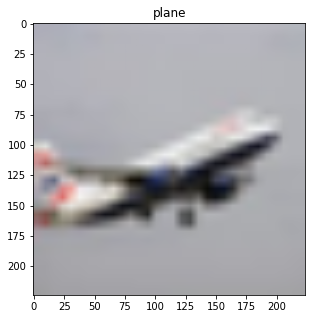

In [19]:
plt.figure(figsize=(5,5))
plt.title(classes[label])
plt.imshow(npimg)

## 모델 설정

In [20]:
model = GooLeNet(3,10).to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [21]:
from torchsummary import summary

summary(model,input_size=(3,224,224), batch_size=batch_size, device= device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 112, 112]           9,472
              ReLU-2        [128, 64, 112, 112]               0
         ConvBlock-3        [128, 64, 112, 112]               0
         MaxPool2d-4          [128, 64, 56, 56]               0
 LocalResponseNorm-5          [128, 64, 56, 56]               0
            Conv2d-6          [128, 64, 56, 56]           4,160
              ReLU-7          [128, 64, 56, 56]               0
         ConvBlock-8          [128, 64, 56, 56]               0
            Conv2d-9         [128, 192, 56, 56]         110,784
             ReLU-10         [128, 192, 56, 56]               0
        ConvBlock-11         [128, 192, 56, 56]               0
LocalResponseNorm-12         [128, 192, 56, 56]               0
        MaxPool2d-13         [128, 192, 28, 28]               0
           Conv2d-14          [128, 64,

##Train

In [22]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    model.set_train()
    for batch_idx, (data,target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        out_1, out_2, out_3 = model(data)
        loss_1 = criterion(out_1,target)
        loss_2 = criterion(out_2,target)
        loss_3 = criterion(out_3,target)
        loss = loss_1 + (0.3*loss_2) + (0.3*loss_3)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx+1)%30 == 0:
            print(f'Train Epoch: {epoch} ({100*(batch_idx+1)*batch_size/len(train_loader.dataset):.0f})%',
                  f'Loss: {loss/batch_size:.4f}')

##Test

In [23]:
def test(model, device, test_loader):
    model.eval()
    model.set_eval()
    test_loss=0
    correct=0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target)
            pred = torch.max(output,1)[1]
            correct += pred.eq(target).sum().item()

        test_loss /= len(test_loader.dataset)
        print(f"\nTest set: Average Loss:{test_loss:.4f}, Accuracy: {100 * correct / len(test_loader.dataset)}%\n")
        print('='*50) 

##학습

In [ ]:
for epoch in range(1,num_epochs+1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 (8)% Loss: 3.6584
Train Epoch: 1 (15)% Loss: 3.4284
Train Epoch: 1 (23)% Loss: 3.3822
Train Epoch: 1 (31)% Loss: 3.1829
Train Epoch: 1 (38)% Loss: 3.1269
Train Epoch: 1 (46)% Loss: 3.2590
Train Epoch: 1 (54)% Loss: 3.0171
Train Epoch: 1 (61)% Loss: 3.0615
Train Epoch: 1 (69)% Loss: 2.5981
Train Epoch: 1 (77)% Loss: 2.7816
Train Epoch: 1 (84)% Loss: 2.9793
Train Epoch: 1 (92)% Loss: 2.5771
Train Epoch: 1 (100)% Loss: 2.4400

Test set: Average Loss:1.5401, Accuracy: 42.98%

Train Epoch: 2 (8)% Loss: 2.4157
Train Epoch: 2 (15)% Loss: 2.7398
Train Epoch: 2 (23)% Loss: 2.1541
Train Epoch: 2 (31)% Loss: 2.4020
Train Epoch: 2 (38)% Loss: 2.3517
Train Epoch: 2 (46)% Loss: 2.3672
Train Epoch: 2 (54)% Loss: 2.1813
Train Epoch: 2 (61)% Loss: 2.2851
Train Epoch: 2 (69)% Loss: 2.2807
Train Epoch: 2 (77)% Loss: 1.9463
Train Epoch: 2 (84)% Loss: 2.0503
Train Epoch: 2 (92)% Loss: 1.9363
Train Epoch: 2 (100)% Loss: 2.0125

Test set: Average Loss:1.1828, Accuracy: 56.73%

Train Epoch: 3 (